In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import MultiExpFrequencyScan

from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
class MFScan(BaseEstimator, RegressorMixin, MultiExpFrequencyScan):

    def __init__(self,
                 n_exps=1,
                 filling_pulse = 20*10**-6,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False):
        
        exps_params = [ [np.random.uniform(low=-3.5, high=-1), 1.0] for _ in range(n_exps) ]

        super().__init__(n_exps=n_exps,
                         filling_pulse = filling_pulse,
                         exps_params=exps_params,
                         learning_rate = learning_rate,
                         n_iters = n_iters,
                         stop_val = stop_val,
                         verbose = verbose,
                         tf_in_out = False
                        )
        
        self.fit_results_ = pd.DataFrame()
        
        
    def fit(self, X, y):
        self.fit_results_ = super().fit(f_powers=X, dlts_vals=y)
        
        return self
    
    
    def predict(self, X):
        return super().__call__(f_powers=X)

In [3]:
frequency_powers = np.linspace(0, 3.5, 1000)
frequency_powers = tf.Variable(frequency_powers, dtype='float64').numpy()

In [4]:
fs = MFScan(n_exps=3, filling_pulse=2*10**-5)

fs.exps_params = [[-1.0, 3.5],
                  [-2.3, 3.0],
                  [-3.5, 2.5]]

experimental_dlts = fs(frequency_powers) 
experimental_dlts += np.random.normal(loc=0, scale=0.2, size=experimental_dlts.shape[0])

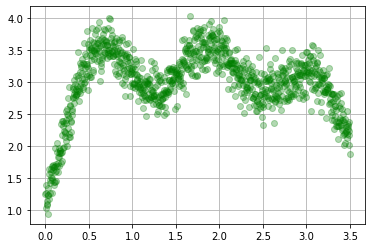

In [5]:
plt.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3)
plt.grid()
plt.show()

In [6]:
n_exps = 3

fs = MFScan(n_exps=n_exps,
            n_iters=200,
            stop_val=10**-5,
            verbose=True
           )

initial_model = fs(frequency_powers)

fs.fit(X=frequency_powers, y=experimental_dlts)

fit_results = fs.fit_results_
fit_results

iter # 0
exps_params:
 [[-2.83695012  1.        ]
 [-1.69163857  1.        ]
 [-1.73599195  1.        ]]
Loss: 4.005097644229205
iter # 1
exps_params:
 [[-2.83495135  1.1247767 ]
 [-1.65853179  1.11956512]
 [-1.7095007   1.11824325]]
Loss: 3.5681382631507357
iter # 2
exps_params:
 [[-2.83887507  1.24109916]
 [-1.61783613  1.22583412]
 [-1.67818832  1.22287127]]
Loss: 3.197985639927645
iter # 3
exps_params:
 [[-2.84675361  1.35062015]
 [-1.57057493  1.32095002]
 [-1.64384409  1.31597333]]
Loss: 2.8767038860090497
iter # 4
exps_params:
 [[-2.8561654   1.45471009]
 [-1.51815686  1.40670937]
 [-1.60880132  1.39929609]]
Loss: 2.5933409041590902
iter # 5
exps_params:
 [[-2.86488444  1.55435765]
 [-1.46220772  1.48452118]
 [-1.57573217  1.4742167 ]]
Loss: 2.341947213183553
iter # 6
exps_params:
 [[-2.87136736  1.65017008]
 [-1.40438773  1.55543877]
 [-1.5473895   1.54179173]]
Loss: 2.1192419291595113
iter # 7
exps_params:
 [[-2.87496608  1.7424395 ]
 [-1.34620656  1.62025236]
 [-1.52631713  1

iter # 63
exps_params:
 [[-3.41701554  2.78930062]
 [-0.98823342  3.22765336]
 [-2.20799688  2.77575243]]
Loss: 0.06705095964541913
iter # 64
exps_params:
 [[-3.41991033  2.78549247]
 [-0.98872369  3.23767311]
 [-2.21075028  2.78147538]]
Loss: 0.06543877742286366
iter # 65
exps_params:
 [[-3.4226923   2.78165796]
 [-0.98920038  3.24732927]
 [-2.21340845  2.787     ]]
Loss: 0.06392828565238019
iter # 66
exps_params:
 [[-3.42536642  2.77780431]
 [-0.98966383  3.25663529]
 [-2.21597534  2.79233463]]
Loss: 0.06251243581465618
iter # 67
exps_params:
 [[-3.42793739  2.77393814]
 [-0.99011441  3.26560412]
 [-2.21845467  2.79748721]]
Loss: 0.0611847132277985
iter # 68
exps_params:
 [[-3.4304097   2.77006551]
 [-0.99055245  3.27424826]
 [-2.22084997  2.80246529]]
Loss: 0.05993909318043704
iter # 69
exps_params:
 [[-3.43278759  2.76619201]
 [-0.99097829  3.28257975]
 [-2.22316461  2.80727608]]
Loss: 0.05877000096270878
iter # 70
exps_params:
 [[-3.4350751   2.76232274]
 [-0.99139223  3.29061019]

iter # 125
exps_params:
 [[-3.48880757  2.60747649]
 [-1.00259955  3.47948973]
 [-2.28280137  2.93507982]]
Loss: 0.04013897927550269
iter # 126
exps_params:
 [[-3.48914997  2.60582589]
 [-1.00267966  3.4806081 ]
 [-2.28321362  2.93606431]]
Loss: 0.04008723435066551
iter # 127
exps_params:
 [[-3.48948247  2.60420906]
 [-1.00275741  3.48168974]
 [-2.2836147   2.93702628]]
Loss: 0.04003796857732586
iter # 128
exps_params:
 [[-3.48980543  2.60262542]
 [-1.00283287  3.48273594]
 [-2.28400494  2.93796634]]
Loss: 0.03999105803139133
iter # 129
exps_params:
 [[-3.49011916  2.60107441]
 [-1.00290612  3.4837479 ]
 [-2.28438466  2.93888509]]
Loss: 0.0399463853462854
iter # 130
exps_params:
 [[-3.49042396  2.59955545]
 [-1.00297721  3.48472683]
 [-2.28475416  2.9397831 ]]
Loss: 0.03990383934019227
iter # 131
exps_params:
 [[-3.49072013  2.59806799]
 [-1.00304621  3.48567384]
 [-2.28511375  2.94066092]]
Loss: 0.039863314666263736
iter # 132
exps_params:
 [[-3.49100796  2.59661146]
 [-1.00311318  3.

,loss,n_exps,time_constatn_power_0,amplitude_0,time_constatn_power_1,amplitude_1,time_constatn_power_2,amplitude_2
0,4.005098,3,-2.836950,1.000000,-1.691639,1.000000,-1.735992,1.000000
1,3.568138,3,-2.834951,1.124777,-1.658532,1.119565,-1.709501,1.118243
2,3.197986,3,-2.838875,1.241099,-1.617836,1.225834,-1.678188,1.222871
3,2.876704,3,-2.846754,1.350620,-1.570575,1.320950,-1.643844,1.315973
4,2.593341,3,-2.856165,1.454710,-1.518157,1.406709,-1.608801,1.399296
...,...,...,...,...,...,...,...,...
157,0.039275,3,-3.496140,2.568730,-1.004273,3.502004,-2.291766,2.957841
158,0.039264,3,-3.496283,2.567901,-1.004304,3.502400,-2.291942,2.958330
159,0.039254,3,-3.496422,2.567089,-1.004334,3.502784,-2.292114,2.958808
160,0.039243,3,-3.496558,2.566296,-1.004363,3.503155,-2.292281,2.959276


In [7]:
fs.exps_params

array([[-3.496819  ,  2.56476047],
       [-1.00441781,  3.50386396],
       [-2.29260335,  2.96018322]])

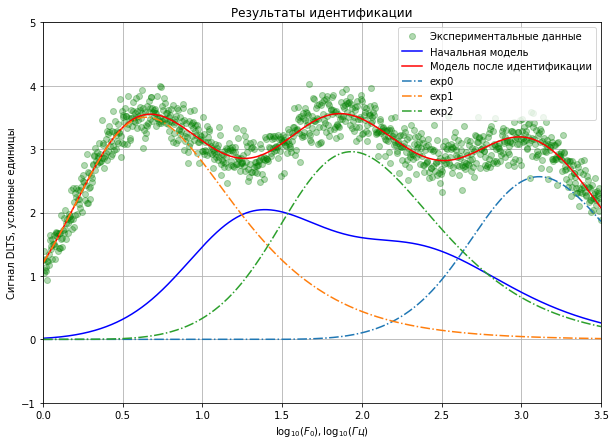

In [8]:
def plot_ident_res(frequency_powers,
                   experimental_dlts, 
                   fit_results
                  ):
    
    n_exps=fit_results.loc[0, 'n_exps']
    
    init_params = fit_results.iloc[0, :]
    init_params = [[init_params[f'time_constatn_power_{i}'], init_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs = MultiExpFrequencyScan(n_exps=n_exps, exps_params=init_params)
    initial_model = fs(frequency_powers)
    
    
    final_params = fit_results.iloc[-1, :]
    final_params = [[final_params[f'time_constatn_power_{i}'], final_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs.exps_params=final_params
    final_model = fs(frequency_powers)
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3, label='Экспериментальные данные')

    ax.plot(frequency_powers, initial_model, '-b', label='Начальная модель')

    ax.plot(frequency_powers, final_model, '-r', label='Модель после идентификации')

    for i, scan in enumerate(fs._fs_list):
        plt.plot(frequency_powers, scan(frequency_powers), '-.', label=f'exp{i}')

    ax.legend()
    ax.grid()
    ax.set_xlim([0, 3.5])
    ylim = ax.get_ylim()
    ylim = [np.floor(ylim[0]), np.ceil(ylim[1])]
    ax.set_ylim(ylim)
    
    ax.set_title('Результаты идентификации')
    ax.set_xlabel(r'$\log_{10}(F_0), \log_{10}(Гц)$')
    ax.set_ylabel('Сигнал DLTS, условные единицы')
    
    return fig, ax


final_model = fs.predict(frequency_powers)

fig, ax = plot_ident_res(frequency_powers,
                         experimental_dlts, 
                         fit_results
                        )

plt.show()

In [9]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'learning_rate': 0.1,
 'n_exps': 3,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': True}

In [10]:
fs.set_params(n_exps=4)

MFScan(n_exps=4, n_iters=200, stop_val=1e-05, verbose=True)

In [11]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'learning_rate': 0.1,
 'n_exps': 4,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': True}